In [12]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


Функции для препроцессинга. Нужно обязательно удалить стоп-слова, а то они заполоняют все темы.

In [62]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum() and word not in stopwords.words('russian')]
    return clean

Загружаем тексты:



In [63]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

Добавляем нграммы:

In [64]:
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.5, 
                           common_terms=set(stopwords.words('russian')))

p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

Переводим в vw-формат:

In [65]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



Функция оценки:

In [26]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

Разбиваем файл и загружаем батчи:

In [66]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',
                                        data_format='vowpal_wabbit',
                                        target_folder='batches',
                                       batch_size=1000)

In [67]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches',
                                        data_format='batches')

Создаем словарь:

In [88]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=25, max_df=2000)

artm.Dictionary(name=7cd6d892-926e-4d21-a422-694fd8c4953e, num_entries=8419)

В словаре оказалось много непонятных слов на латинице, наверное, это какие-то программистские термины, потому что тексты с хабра. На всякий случай повысим минимальный порог.

In [89]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

На первый взгляд кажется, что стало лучше.

Обучим первую модель с уменьшенным (но положительным) тау для регуляризатора сглаживания и увеличенным для регуляризатора декорелляции.

In [90]:
model_artm_1 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.5, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.1, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )
model_artm_1.initialize(dictionary=dictionary)

In [91]:
model_artm_1.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm_1.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm_1.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm_1.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm_1.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

Обучаем модель. Увеличим число итераций



In [92]:
model_artm_1.num_document_passes = 2
model_artm_1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Добавляем регуляризаторы разреженности.

In [93]:
model_artm_1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm_1.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [94]:
model_artm_1.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [95]:
phi_tau = model_artm_1.regularizers['SparsePhi'].tau
theta_tau = model_artm_1.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm_1.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm_1.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm_1.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Теперь обучим вторую модель с другими параметрами и сделаем все то же самое:

In [98]:
model_artm_2 = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.3, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.2, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 100)])
                                    ]
                        )
model_artm_2.initialize(dictionary=dictionary)

In [99]:
model_artm_2.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm_2.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm_2.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm_2.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm_2.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы

In [100]:
model_artm_2.num_document_passes = 2
model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

In [102]:
model_artm_2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 100)],
                                                            ))
model_artm_2.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 100)]))

In [103]:
model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [105]:
phi_tau = model_artm_2.regularizers['SparsePhi'].tau
theta_tau = model_artm_2.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm_2.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm_2.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm_2.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Две модели, которые я обучила, различались, во-первых, количеством тем (200 и 100 соответственно), а во-вторых, значениями тау у регуляризаторов. Они показали примерно одинаковый результат (перплексия 244 у первой и 270 у второй), я буду описывать вторую, т.к.в нее было внесено больше изменений.

Вот три хороших темы:

topic_1: 
устройство
уязвимость
атака
защита
злоумышленник
сеть
уровень
данные
угроза
атаковать

topic_16: 
доклад
всё
проект
конференция
выступление
человек
день
хороший
интересный
спикер

topic_19: 
the
to
in
a
for
end
on
and
is
i

График обучения:




Sparsity Phi: 0.292 ARTM)
Sparsity Theta: 0.030 (ARTM)
Kernel contrast: 0.190 (ARTM)
Kernel purity: 0.180 (ARTM)
Perplexity: 270.929 (ARTM)


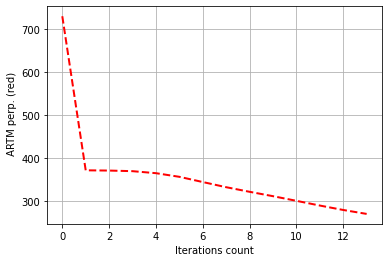

In [106]:
print_measures(model_artm_2)

Модель работала со 100 темами и двумя регуляризаторами: декорреляции (tau=0.3) и сглаживания (tau=0.2). Перплексия модели начала снижаться особенно активно после четвертой итерации обучения.